### Exploring the WMS with OWSLib

In [1]:
from owslib.wms import WebMapService
url = 'http://localhost:8082/geoserver/ows'
wms = WebMapService(url, version='1.1.1')
[i for i in wms.contents.keys() if i.startswith("geonode:")]

['geonode:NDVIs',
 'geonode:timeseries_overall',
 'geonode:DNI_yearly',
 'geonode:NDVI_20010101',
 'geonode:NDVI_20050101',
 'geonode:NDVI_20050301',
 'geonode:NDVI_20050601',
 'geonode:NDVI_20050901',
 'geonode:NDVI_20100101',
 'geonode:PVOUT',
 'geonode:PVOUT_yearly',
 'geonode:TEMP_yearly',
 'geonode:demand',
 'geonode:kwh_sq',
 'geonode:ne_10m_admin_0_countries',
 'geonode:timeseries']

### Layer metadata

In [2]:
layer = 'geonode:timeseries'
wms[layer].title

'timeseries'

In [3]:
wms[layer].boundingBoxWGS84

(21.5656676639333, 35.4912750199959, 24.2360084795257, 41.2538015034461)

In [4]:
wms[layer].styles

{'geonode:timeseries': {'title': 'geonode:timeseries',
  'legend': 'http://localhost:8082/geoserver/wms?request=GetLegendGraphic&format=image%2Fpng&width=20&height=20&layer=geonode%3Atimeseries'},
 'geonode:labels': {'title': 'geonode:labels',
  'legend': 'http://localhost:8082/geoserver/wms?request=GetLegendGraphic&format=image%2Fpng&width=20&height=20&layer=geonode%3Atimeseries&style=labels'}}

In [30]:
[op.name for op in wms.operations]

['GetCapabilities',
 'GetMap',
 'GetFeatureInfo',
 'DescribeLayer',
 'GetLegendGraphic',
 'GetStyles']

In [31]:
# Get map function
import os, sys

def getMap(layer, bbox, filename, style=None):
    wms.getOperationByName('GetMap').formatOptions
    img = wms.getmap(layers=[layer],
                     size=(688,398),
                     srs='EPSG:4326',
                     bbox=bbox,
                     format= 'image/png', 
                     transparent=True,
                     style=style)
    f = open (filename, 'wb')
    f.write(img.read())
    f.close()

In [32]:
wms['geonode:timeseries'].styles

{'geonode:timeseries': {'title': 'geonode:timeseries',
  'legend': 'http://localhost:8082/geoserver/wms?request=GetLegendGraphic&format=image%2Fpng&width=20&height=20&layer=geonode%3Atimeseries'},
 'geonode:labels': {'title': 'geonode:labels',
  'legend': 'http://localhost:8082/geoserver/wms?request=GetLegendGraphic&format=image%2Fpng&width=20&height=20&layer=geonode%3Atimeseries&style=labels'}}

## Show municipalities with timeseries (static)

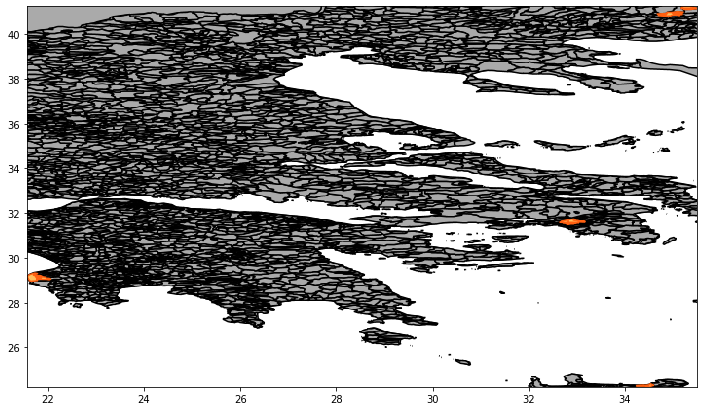

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


getMap("geonode:timeseries", wms[layer].boundingBoxWGS84, "wms/timeseries.png", 'geonode:timseries')
getMap("geonode:ne_10m_admin_0_countries", wms[layer].boundingBoxWGS84, "wms/countries.png")
getMap( "geonode:kwh_sq",wms[layer].boundingBoxWGS84, "wms/kwh_sq.png")

img1 = mpimg.imread("wms/countries.png")
img2 = mpimg.imread("wms/kwh_sq.png")
img3 = mpimg.imread("wms/timeseries.png")
fig = plt.figure(figsize=(12,7))


plt.imshow(img1, extent=wms[layer].boundingBoxWGS84, aspect="auto")
plt.imshow(img2, extent=wms[layer].boundingBoxWGS84, aspect="auto")
plt.imshow(img3, extent=wms[layer].boundingBoxWGS84, aspect="auto")
plt.show()
#plt.savefig("wms/skata.png")

# WFS

## Geoserver WFS inspection using OWSlib

In [16]:
from owslib.wfs import WebFeatureService
wfs = WebFeatureService(url='http://127.0.0.1:8082/geoserver/wfs', version='1.1.0')
wfs.identification.title

'GeoServer Web Feature Service'

In [17]:
[operation.name for operation in wfs.operations]

['GetCapabilities',
 'DescribeFeatureType',
 'GetFeature',
 'GetGmlObject',
 'LockFeature',
 'GetFeatureWithLock',
 'Transaction']

My workspace layers that support WFS.

In [ ]:
[i for i in wfs.contents.keys() if i.startswith("geonode:")]

## WFS custom function for downloading vector layers from geoserver to the disk through OWSLib.

In [ ]:
import pandas as pd
import folium
from folium import plugins
import geopandas as gpd
import json
import os

def getFeature(layer, bbox=None, workspace="geonode", format="json"):
    if bbox:
        response = wfs.getfeature(typename=workspace+":"+layer, outputFormat=format, bbox=bbox)
    else:
        response = wfs.getfeature(typename=workspace+":"+layer, outputFormat=format)
    with open(os.path.join("wfs", layer+"."+format), 'wb') as f:
        while True:
            data = response.read(100)
            if not data:
                break
            f.write(data)
    name=f.name
    f.close
    return (name)

## WFS calls to geoserver in order to store layer as vector (csv & GeoJson) to the disk

In [ ]:
#width, height = 480, 350
layer = "kwh_sq"
geodata = getFeature(layer, format="json")
data = pd.read_csv(getFeature(layer, format="csv"))
data.head()
with open(os.path.join("wfs",layer+".json")) as f:
    data_geojson = json.loads(f.read())

### Choropleth map using the wfs downloaded files

In [ ]:
m = folium.Map(location=[37, 23], zoom_start=6, tiles='Cartodb Positron') #width=width, height=height)
                   
folium.Choropleth(
    geo_data=geodata,
    name='Heat demand density',
    data=data[["mun", "heat", "geom"]],
    columns=['mun','heat'],
    key_on='feature.properties.mun',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='kwh / m^2',
    overlay=True,
    #bins=list(data.heat.quantile([0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.8, 1])),
    reset=False,
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=['mun', 'heat', 'water'],
#         aliases=['Municipality:', 'Energy demand for heat [kwh/sq_m]:', 'Energy demand for water [kwh/sq_m]:' ]
#     )
).add_to(m)

# search
# plugins.Search(folium.GeoJson(data=data_geojson, name='Heat demand density'), search_zoom=6, geom_type='Polygon').add_to(m)
#folium.LayerControl().add_to(m)
m

# WCS

In [ ]:
from owslib.wcs import WebCoverageService
#from PIL import image
%matplotlib inline

In [ ]:
wcs = WebCoverageService('http://localhost:8082/geoserver/ows', version='1.0.0')

In [ ]:
[i for i in wcs.contents.keys() if i.startswith("geonode:")]

In [ ]:
layer = "geonode:PVOUT"

In [ ]:
wcs[layer].abstract

In [ ]:
wcs[layer].boundingBoxWGS84

In [ ]:
[op.name for op in wcs.operations]

In [ ]:
### WCS function for instant download

In [ ]:
import pandas as pd
import folium
from folium import plugins
import geopandas as gpd
import json
import os
import webbrowser

def wcs_download(layer, bbox=[-180, -90, 180, 90], workspace="geonode", format="GeoTIFF", height=256, width=256):
    response = wcs.getCoverage(identifier="geonode"+":"+layer, format=format, height=height, width=width, crs="EPSG:4326", bbox=bbox)
    webbrowser.open(response.geturl())
    return response.geturl()

In [ ]:
wcs_download("PVOUT", bbox=[20,33,35,40], format="IMAGEMOSAIC")